# Amazon reviews

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

### Download the data
We will use the 5-core reviews
http://jmcauley.ucsd.edu/data/amazon/

### File preparation

To prepare the file and be able to read it properly, the following sed commands must be used:

```sh
sed -i '1s/^/[/' data/file.json # Starts JSON array
sed -i -e 's/}/},/g' data/file.json # Separate objects with commas
sed -i '$ s/,$/]/g' data/file.json # Ends JSON array
```

### Data importation

We will start by focusing on one specific product subsection, here video games. (http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz)

In [2]:
video_games = pd.read_json('./data/video-games.json')

# Cleaning dates
del video_games['reviewTime'] # Duplicated information (already in unix review time)
video_games['date'] = pd.to_datetime(video_games['unixReviewTime'], unit='s')
del video_games['unixReviewTime']

video_games.set_index(['asin', 'reviewerID'], inplace=True)
video_games.dtypes

helpful                 object
overall                  int64
reviewText              object
reviewerName            object
summary                 object
date            datetime64[ns]
dtype: object

### Data cleaning

In [3]:
def helpful_rate(row):
    was_helpful = row.helpful[0]
    total_evaluations = row.helpful[1]
    
    if total_evaluations == 0:
        return -1
    
    return was_helpful/total_evaluations

video_games['helpfulRate'] = video_games.apply(helpful_rate, axis=1)

assert video_games.index.is_unique # There is no more than one review per person per product

video_games.head()

helpful  overall  \
asin       reviewerID                         
0700099867 A2HD75EMZR8QLN  [8, 12]        1   
           A3UR8NLLY1ZHCX   [0, 0]        4   
           A1INA0F5CWW3J4   [0, 0]        1   
           A1DLMTOTHQ4AST  [7, 10]        3   
           A361M14PU2GUEG   [2, 2]        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  
asin       reviewerID                              
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667  
           A3UR8NLLY1ZHCX 2013-06-30    -1.000000  
           A1INA0F5CWW3J4 2014-06-28    -1.000000  
           A1DLMTOTHQ4AST 2011-09-14     0.700000  
           A361M14PU2GUEG 2011-06-14     1.000000

### Descriptive analysis

We first use pandas built-in functions to describe data:

In [4]:
video_games.overall.describe()

count    231780.000000
mean          4.086397
std           1.202330
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

We have 231780 reviews, with a mean of 4.08 and a standard deviation of 1.20.

When focusing at robust statistics only, we can see that the median is 5, and more than 75% of the reviews have awarded 4 or 5 grade to the product.

We do the same description for the helpful rate (after removing the reviews without evaluation):

In [5]:
video_games[video_games.helpfulRate >= 0].helpfulRate.describe()

count    139855.000000
mean          0.622347
std           0.369065
min           0.000000
25%           0.333333
50%           0.695652
75%           1.000000
max           1.000000
Name: helpfulRate, dtype: float64

Distribution seems more balanced, since first quartile is 0.33, median is 0.69 and last quartile is 0.75.

We now look at the repartition of evaluations, considering all the sold products.

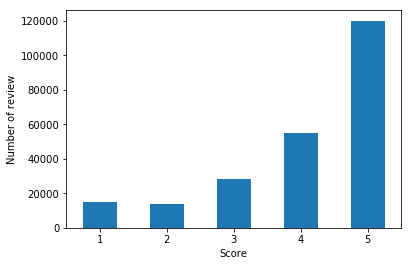

In [6]:
plt.xlabel('Score')
plt.ylabel('Number of review')
video_games.overall.value_counts(ascending=True).sort_index().plot(kind='bar', rot=0)

We observe that there is higher 5-score review than the others.  
Intepretations : 
- The people are more likely to thanks the product quality by posting a review than to say his displeasure
- Amazon sell more good quality product (here video game) than bad one
- The 5 stars review can be due to the presence of fakes/paid review.

60.34% of reviews are evaluated


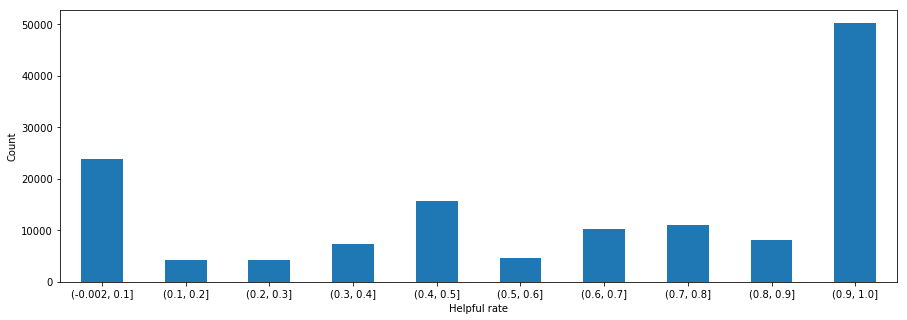

In [7]:
# We get all the "helpfulness rates" (removing the unrated comments)
helpfulRates = video_games[video_games.helpfulRate >= 0].helpfulRate

print(str(round(len(helpfulRates) * 100 / len(video_games.helpfulRate), 2)) + '% of reviews are evaluated')

plt.xlabel('Helpful rate')
plt.ylabel('Count')
helpfulRates.value_counts(ascending=True, bins=10).sort_index().plot(kind='bar', rot=0, figsize=(15, 5))

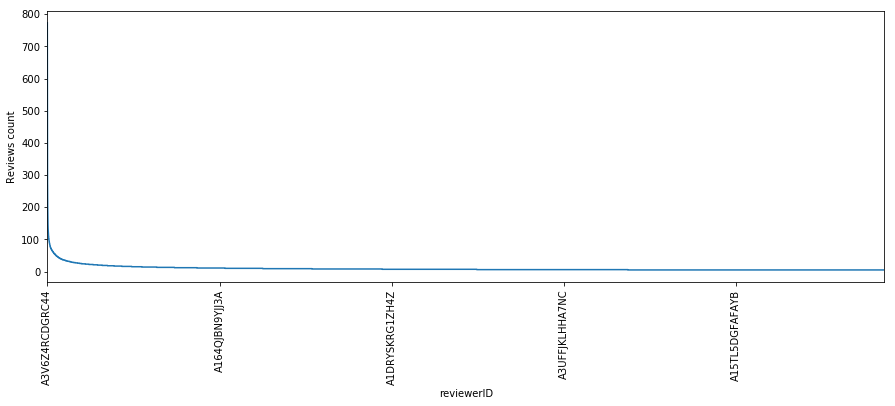

In [8]:
count_evaluations = video_games.groupby('reviewerID').count().sort_values('helpful', ascending=False).helpful

plt.ylabel('Reviews count')
count_evaluations.plot(rot=90, figsize=(15, 5))

Zooming to get only evaluators with more than 30 evaluations. We can see that evaluations are done by a restricted number of evaluators providing the majority of evaluations.

1st best evaluator: 773
2nd best evaluator: 635
3rd best evaluator: 450
4th best evaluator: 404
5th best evaluator: 320


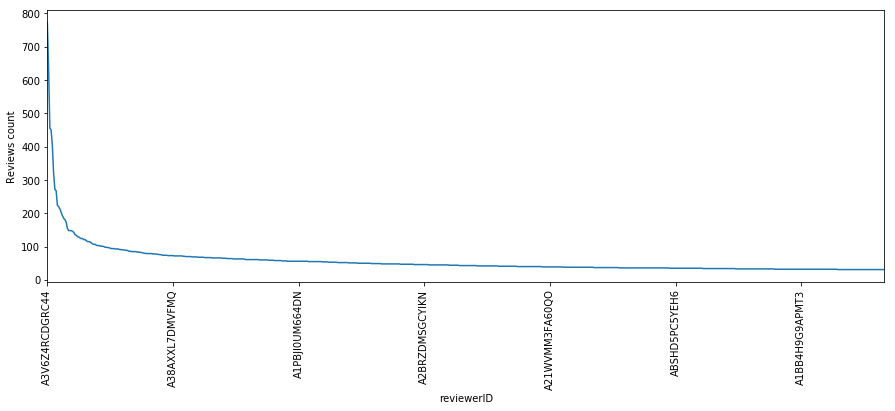

In [9]:
top_count_evaluations = count_evaluations[count_evaluations > 30]
plt.ylabel('Reviews count')
top_count_evaluations.plot(rot=90, figsize=(15, 5))

print('1st best evaluator: ' + str(top_count_evaluations[0]))
print('2nd best evaluator: ' + str(top_count_evaluations[1]))
print('3rd best evaluator: ' + str(top_count_evaluations[3]))
print('4th best evaluator: ' + str(top_count_evaluations[4]))
print('5th best evaluator: ' + str(top_count_evaluations[5]))

We seem to have a power law here. We try to confirm this using a logarithmic plot:

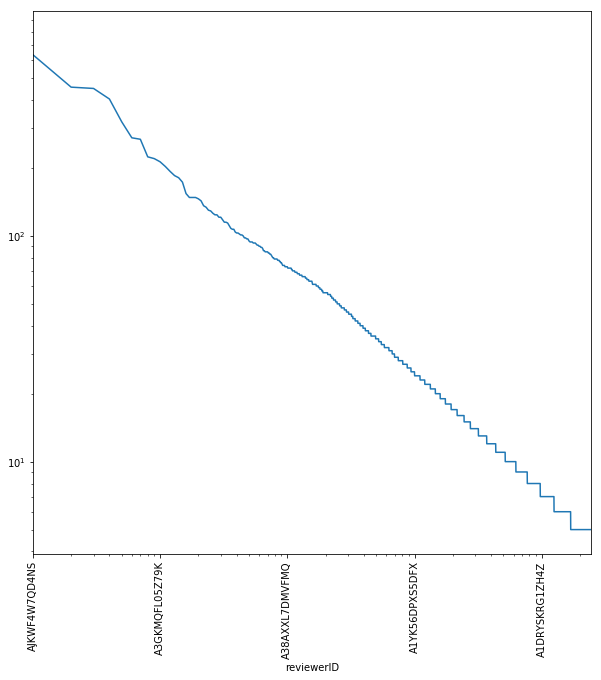

In [10]:
import warnings
warnings.simplefilter('ignore') # Ignoring warning about non positive xlimit

count_evaluations.plot(logy=True, logx=True, rot=90, figsize=(10, 10))

Focusing on the best evaluator, let's see if he provides well rated evaluations:

In [11]:
best_reviewer_id = top_count_evaluations.index[0]

video_games.groupby('reviewerID').get_group(best_reviewer_id).mean()

overall        4.316947
helpfulRate    0.636186
dtype: float64

Comparing it with all the others.

In [12]:
video_games.overall.median()

5.0

In [13]:
video_games[video_games.helpfulRate >= 0].helpfulRate.median()

0.6956521739130435

The best evaluator seems to be a normal person, his helpfulRate is close to the median.

#### Correlations
We add column "reviewLength", "summaryLength" and "reviewerNameLength" to the dataframe

In [14]:
video_games['reviewLength'] = video_games['reviewText'].str.len()
video_games['summaryLength'] = video_games['summary'].str.len()
video_games['reviewerNameLength'] = video_games['reviewerName'].str.len()

video_games.head()

helpful  overall  \
asin       reviewerID                         
0700099867 A2HD75EMZR8QLN  [8, 12]        1   
           A3UR8NLLY1ZHCX   [0, 0]        4   
           A1INA0F5CWW3J4   [0, 0]        1   
           A1DLMTOTHQ4AST  [7, 10]        3   
           A361M14PU2GUEG   [2, 2]        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  reviewLength  \
asin       reviewerID                                             
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667           779   
           A3UR8NLLY1ZHCX 2013-06-30    -1.000000           304   
           A1INA0F5CWW3J4 2014-06-28    -1.000000           282   
           A1DLMTOTHQ4AST 2011-09-14     0.700000          3489   
           A361M14PU2GUEG 2011-06-14     1.000000           294   

                           summaryLength  reviewerNameLength  
asin       reviewerID                                         
0700099867 A2HD75EMZR8QLN             40                 3.0  
           A3UR8NLLY1ZHCX             15                34.0  
           A1INA0F5CWW3J4              9                26.0  
           A1DLMTOTHQ4AST             47                 8.0  
           A361M14PU2GUEG              6                28.0

We display the correlation matrix and scatter plot

In [15]:
video_games.corr()

,overall,helpfulRate,reviewLength,summaryLength,reviewerNameLength
overall,1.000000,-0.133272,-0.062702,-0.074934,-0.009812
helpfulRate,-0.133272,1.000000,0.294168,0.176459,0.099486
reviewLength,-0.062702,0.294168,1.000000,0.309684,0.098276
summaryLength,-0.074934,0.176459,0.309684,1.000000,0.094540
reviewerNameLength,-0.009812,0.099486,0.098276,0.094540,1.000000


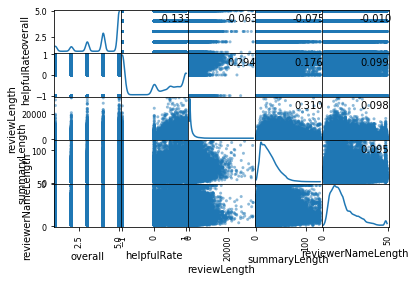

In [16]:
from pandas.tools.plotting import scatter_matrix

axes = scatter_matrix(video_games, alpha=0.5, diagonal='kde')
corr = video_games.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

plt.show()

There is some correlation between between review length and the helpful rate.
We can think that more the review length is high, more the review can contain more descriptions and arguments, so it can increase the helpfullness.   
Then, the summary length and the review length seems to be also correlated. The more the review text is lengthy, the more the summary needs letters to summarize it.